In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import traffic as t
import os
import datetime

In [4]:
datapath = '../../Data'

In [9]:
fuel_train = pd.read_parquet(os.path.join(datapath, "fuel_train.parquet"), engine="fastparquet")
flightlist_train = pd.read_parquet(os.path.join(datapath, "flightlist_train.parquet"), engine="fastparquet")

fuel_test = pd.read_parquet(os.path.join(datapath, "fuel_rank_submission.parquet"), engine="fastparquet")
flightlist_test = pd.read_parquet(os.path.join(datapath, "flightlist_rank.parquet"), engine="fastparquet")

In [10]:
# Pre processing

# Prepare training set
fuel_train['hrs'] = (fuel_train['end'] - fuel_train['start']).dt.seconds / 3600
fuel_train['kg/hr'] = fuel_train['fuel_kg'] / fuel_train['hrs']

fuel_train = fuel_train.join(flightlist_train.set_index('flight_id'), on='flight_id')

# Prepare test set
fuel_test['hrs'] = (fuel_test['end'] - fuel_test['start']).dt.seconds / 3600
fuel_test['kg/hr'] = fuel_test['fuel_kg'] / fuel_test['hrs']

fuel_test = fuel_test.join(flightlist_test.set_index('flight_id'), on='flight_id')


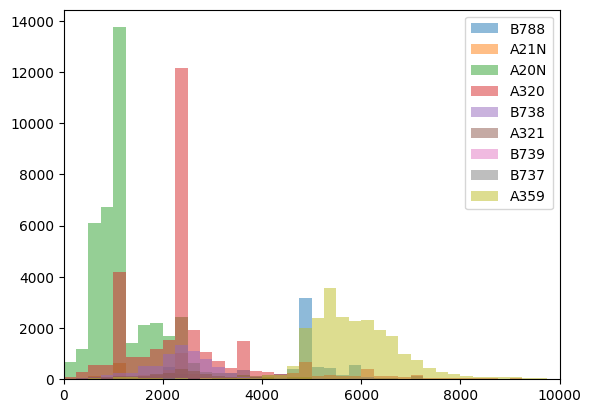

In [11]:
f, a = plt.subplots()

acs = ['B788', 'A21N', 'A20N', 'A320', 'B738', 'A321', 'B739', 'B737', 'A359']
# acs = fuel_train['aircraft_type'].unique()

maxbin = max(fuel_train['kg/hr'])

for ac in acs:
    subset = fuel_train[fuel_train['aircraft_type'] == ac]

    a.hist(subset['kg/hr'], alpha = 0.5, bins = range(0, round(maxbin) + 250, 250))

a.set_xlim([0, 10000])
a.legend(acs)

In [ ]:
ackey = fuel_train['aircraft_type'].unique()

meanburns = {}

for (i, ac) in enumerate(ackey):
    meanburns[ac] = np.mean(fuel_train['kg/hr'])


In [ ]:
fuel_test['kg/hr'] = fuel_test['aircraft_type'].map(lambda x: meanburns[x])
fuel_test['fuel_kg'] = fuel_test['kg/hr'] * fuel_test['hrs']

submission = fuel_test[['idx', 'flight_id', 'start', 'end', 'fuel_kg']]

In [16]:
def schema_report(df, name):
    print(f"\n== {name} dtypes ==")
    print(df.dtypes)
    print(f"\nNA counts in {name}:")
    print(df.isna().sum())

schema_report(fuel_train, "fuel_train")
schema_report(fuel_test, "fuel_test")
schema_report(flightlist_train, "flightlist_train")
schema_report(flightlist_test, "flightlist_test")


== fuel_train dtypes ==
idx                          int64
flight_id                   object
start               datetime64[ns]
end                 datetime64[ns]
fuel_kg                    float64
hrs                        float64
kg/hr                      float64
flight_date                 object
aircraft_type               object
takeoff             datetime64[us]
landed              datetime64[us]
origin_icao                 object
origin_name                 object
destination_icao            object
destination_name            object
dtype: object

NA counts in fuel_train:
idx                 0
flight_id           0
start               0
end                 0
fuel_kg             0
hrs                 0
kg/hr               0
flight_date         0
aircraft_type       0
takeoff             0
landed              0
origin_icao         0
origin_name         0
destination_icao    0
destination_name    0
dtype: int64

== fuel_test dtypes ==
idx                          int64
flight_i

kg/hr 0.5%..99.5%: 236.0655737704918 15437.522368421023


,count,mean,std,min,1%,5%,50%,95%,99%,max
kg_per_hr,131530.0,3363.291693,2755.372250,35.643564,331.418600,546.130836,2408.026756,7476.796697,12000.000000,59602.649007
hrs,131530.0,0.147621,0.155468,0.000278,0.008889,0.025278,0.083333,0.500278,0.809086,0.999722
fuel_kg,131530.0,557.705484,883.558032,0.453592,16.329312,45.359200,200.000000,2200.000000,4469.241976,32205.032000


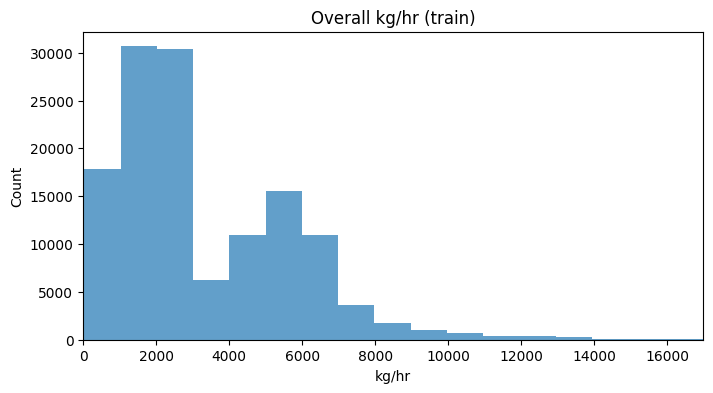

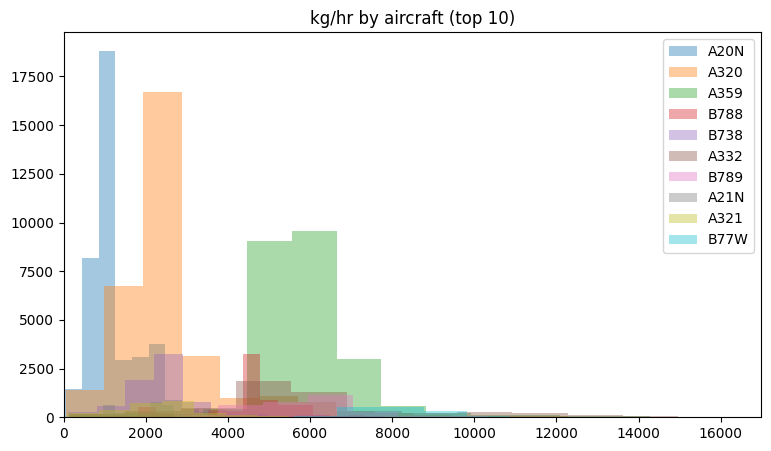

In [20]:
fuel_train["kg_per_hr"] = fuel_train["fuel_kg"] / fuel_train["hrs"]
# simple outlier flags (just to see tails)
q_hi = fuel_train["kg_per_hr"].quantile(0.995)
q_lo = fuel_train["kg_per_hr"].quantile(0.005)
print("kg/hr 0.5%..99.5%:", q_lo, q_hi)

display(
    fuel_train[["kg_per_hr","hrs","fuel_kg","aircraft_type"]]
    .describe(percentiles=[.01,.05,.5,.95,.99])
    .T
)

topN = 10
top_acs = (
    fuel_train["aircraft_type"]
    .value_counts()
    .head(topN)
    .index.tolist()
)

fig, ax = plt.subplots(figsize=(8,4))
ax.hist(fuel_train["kg_per_hr"].clip(lower=0), bins=60, alpha=0.7)
ax.set_title("Overall kg/hr (train)")
ax.set_xlabel("kg/hr")
ax.set_ylabel("Count")
ax.set_xlim(left=0, right=q_hi*1.1)
plt.show()

fig, ax = plt.subplots(figsize=(9,5))
for ac in top_acs:
    sub = fuel_train.loc[fuel_train["aircraft_type"]==ac, "kg_per_hr"].clip(lower=0)
    ax.hist(sub, bins=40, alpha=0.4, label=ac)
ax.set_xlim(left=0)
ax.set_title(f"kg/hr by aircraft (top {topN})")
ax.set_xlim(right=q_hi*1.1)
ax.legend()
plt.show()

In [21]:
submission.to_parquet("friendly-raccoon_v1.parquet", engine="fastparquet")

In [22]:
for df in (fuel_train, fuel_test):
    for c in ("start","end","takeoff","landed"):
        if c in df.columns:
            df[c] = pd.to_datetime(df[c], utc=True)
    df["hrs"] = (df["end"] - df["start"]).dt.total_seconds() / 3600.0

if "kg/hr" in fuel_train.columns: fuel_train = fuel_train.drop(columns=["kg/hr"])
if "kg/hr" in fuel_test.columns:  fuel_test  = fuel_test.drop(columns=["kg/hr"])

fuel_train["kg_per_hr"] = fuel_train["fuel_kg"] / fuel_train["hrs"]

In [ ]:
def trimmed_mean(s, p=0.02):
    lo, hi = s.quantile([p, 1-p])
    return s.clip(lo, hi).mean()

ac_mean_trim = (
    fuel_train.groupby("aircraft_type")["kg_per_hr"]
    .apply(lambda s: trimmed_mean(s, p=0.02))
    .to_dict()
)
global_mean = float(trimmed_mean(fuel_train["kg_per_hr"], p=0.02))

def pred_ac_only(ac):
    return ac_mean_trim.get(ac, global_mean)

fuel_test["kgph_ac"] = fuel_test["aircraft_type"].map(pred_ac_only)

In [24]:
def pos_in_flight_fraction(df):
    mid = df["start"] + (df["end"] - df["start"]) / 2
    total = (df["landed"] - df["takeoff"]).dt.total_seconds()
    frac = (mid - df["takeoff"]).dt.total_seconds() / np.where(total<=0, np.nan, total)
    return pd.Series(frac).clip(-0.25, 1.25)

for df in (fuel_train, fuel_test):
    df["pos_frac"] = pos_in_flight_fraction(df)
    # if a flight has identical times, pos_frac can be NaN; fine, we'll fall back
    df["pos_bin"] = pd.qcut(df["pos_frac"], q=10, labels=False, duplicates="drop")

grid_mean = (
    fuel_train.dropna(subset=["pos_bin"])
              .groupby(["aircraft_type","pos_bin"])["kg_per_hr"]
              .apply(lambda s: trimmed_mean(s, p=0.02))
              .to_dict()
)
bin_mean = (
    fuel_train.dropna(subset=["pos_bin"])
              .groupby("pos_bin")["kg_per_hr"]
              .apply(lambda s: trimmed_mean(s, p=0.02))
              .to_dict()
)

def pred_ac_pos(ac, pb):
    key = (ac, pb)
    if key in grid_mean:   return grid_mean[key]
    if ac in ac_mean_trim: return ac_mean_trim[ac]
    if pb in bin_mean:     return bin_mean[pb]
    return global_mean

fuel_test["kgph_acpos"] = [
    pred_ac_pos(ac, pb) for ac, pb in zip(fuel_test["aircraft_type"], fuel_test["pos_bin"])
]

In [ ]:
fuel_train["_kgph_ac"] = fuel_train["aircraft_type"].map(pred_ac_only)
fuel_train["dur_bin"] = pd.cut(fuel_train["hrs"], bins=[0, .1, .25, .5, 1, 2, 10], right=False)

dur_factor = (
    fuel_train.dropna(subset=["_kgph_ac"])
              .assign(ratio = fuel_train["kg_per_hr"] / fuel_train["_kgph_ac"].replace(0, np.nan))
              .groupby("dur_bin")["ratio"].median()
              .to_dict()
)

def adjust_by_duration(kgph, hrs):
    bins = [0, .1, .25, .5, 1, 2, 10]
    labels = pd.IntervalIndex.from_breaks(bins, closed="left")
    idx = np.searchsorted(bins, hrs, side="right") - 1
    if idx < 0: idx = 0
    if idx >= len(labels): idx = len(labels)-1
    return kgph * float(dur_factor.get(labels[idx], 1.0))

fuel_test["kgph_acpos_dur"] = [
    adjust_by_duration(k, h) for k, h in zip(fuel_test["kgph_acpos"], fuel_test["hrs"])
]

C:\Users\mhomo\AppData\Local\Temp\ipykernel_19776\4213684822.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("dur_bin")["ratio"].median()


In [ ]:
fuel_test = fuel_test.sort_values(["flight_id","start"]).copy()

def smooth_group(g, col="kgph_acpos_dur", win=3):
    s = g[col].astype("float64")
    sm = s.rolling(win, min_periods=1).mean()
    g[col + "_sm"] = sm
    return g

fuel_test = fuel_test.groupby("flight_id", group_keys=False).apply(smooth_group, col="kgph_acpos_dur", win=3)

C:\Users\mhomo\AppData\Local\Temp\ipykernel_19776\2179424271.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  fuel_test = fuel_test.groupby("flight_id", group_keys=False).apply(smooth_group, col="kgph_acpos_dur", win=3)


In [ ]:
pred_col = "kgph_acpos_dur_sm" if "kgph_acpos_dur_sm" in fuel_test.columns else "kgph_acpos_dur"
fuel_test["fuel_kg"] = (fuel_test[pred_col] * fuel_test["hrs"]).clip(lower=0)

submission = (
    fuel_test[["idx","flight_id","start","end","fuel_kg"]]
    .sort_values("idx")
    .reset_index(drop=True)
    .astype({"idx":"int64","flight_id":"string","fuel_kg":"float64"})
)

out_name = "friendly-raccoon_v3.parquet"
try:
    submission.to_parquet(out_name, engine="pyarrow", index=False)
    print(f"Saved {out_name} via pyarrow")
except Exception as e:
    print("pyarrow failed:", e)
    submission.to_parquet(out_name, engine="fastparquet", index=False)
    print(f"Saved {out_name} via fastparquet")

submission.head(8)

pyarrow failed: A type extension with name pandas.period already defined
Saved friendly-raccoon_v2_quickwins.parquet via fastparquet


,idx,flight_id,start,end,fuel_kg
0,0,prc806615763,2025-09-01 03:03:10.925000+00:00,2025-09-01 03:07:51.584000+00:00,162.901614
1,1,prc806615763,2025-09-01 03:07:51.584000+00:00,2025-09-01 03:12:50.921000+00:00,173.742800
2,2,prc806615763,2025-09-01 03:12:50.921000+00:00,2025-09-01 03:17:51.404000+00:00,174.407967
3,3,prc806615763,2025-09-01 03:17:51.404000+00:00,2025-09-01 03:22:50.539000+00:00,173.625554
4,4,prc806615763,2025-09-01 03:22:50.539000+00:00,2025-09-01 03:27:50.727000+00:00,172.300564
5,5,prc806615763,2025-09-01 03:27:50.727000+00:00,2025-09-01 03:32:50.802000+00:00,170.300256
6,6,prc806615763,2025-09-01 03:32:50.802000+00:00,2025-09-01 03:37:51.778000+00:00,168.870336
7,7,prc806615763,2025-09-01 03:37:51.778000+00:00,2025-09-01 03:42:50.706000+00:00,167.721253
